In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt

from apbplotlib.colors import reanalysis_color

In [3]:
data_path = r'/home/apbarret/data/NPSNOW'
bogd_path = os.path.join(data_path, 'Bogdanova2002', 'bogdanova2002_table4.xlsx')
yang_path = os.path.join(data_path, 'yang_precip', r'NPP-yang_copy_apb.xlsx')

In [4]:
def load_reanalysis():

    filepath = {
        'ERA5': '/projects/arctic_scientist_data/Reanalysis/ERA5/daily/TOTPREC/era5.single_level.PRECIP_STATS.annual.Nh50km.npsnow_region.csv',
        'ERAI': '/disks/arctic5_raid/abarrett/ERA_Interim/daily/PRECTOT/era_interim.PRECIP_STATS.annual.Nh50km.npsnow_region.csv',
        'MERRA': '/disks/arctic5_raid/abarrett/MERRA/daily/PRECTOT/MERRA.prod.PRECIP_STATS.assim.tavg1_2d_flx_Nx.annual.Nh50km.npsnow_region.csv',
        'MERRA2': '/disks/arctic5_raid/abarrett/MERRA2/daily/PRECTOT/MERRA2.tavg1_2d_flx_Nx.PRECIP_STATS.annual.Nh50km.npsnow_region.csv',
        'CFSR': '/disks/arctic5_raid/abarrett/CFSR/TOTPREC/CFSR.flxf06.gdas.PRECIP_STATS.annual.EASE_NH50km.npsnow_region.csv',
        'JRA55': '/projects/arctic_scientist_data/Reanalysis/JRA55/daily/TOTPREC/JRA55.fcst_phy2m.PRECIP_STATS.annual.Nh50km.npsnow_region.csv',
    }
    
    def load_one(fp):
        return pd.read_csv(fp, index_col=0, header=0, parse_dates=True)['prectot']
    
    df = pd.concat([load_one(fp) for fp in filepath.values()], axis=1, keys=filepath.keys())
    
    return df

In [5]:
def read_yang(filepath):
    df = pd.read_excel(filepath, sheet_name='monthly-all', 
                       header=0, skiprows=[1,2,3], usecols=range(15), 
                       na_values='-')
    df = df.dropna(how='all')
    
    yyyy = 1900 + df['YY'].values.astype(int)
    mm = df['MM'].values.astype(int)
    df.index = [dt.datetime(y,m,1) for y, m in zip(yyyy, mm)]
    
    return df

In [6]:
def read_bogdanova(filepath):
    df = pd.read_excel(filepath, sheet_name='Sheet1', header=0)
    df.index = [dt.datetime(y,1,1) for y in df.Year]
    return df

In [7]:
reanalysis = load_reanalysis()
reanalysis.describe()

,ERA5,ERAI,MERRA,MERRA2,CFSR,JRA55
count,40.000000,40.000000,37.000000,39.000000,40.000000,40.000000
mean,264.343847,237.795620,224.948025,310.441447,331.207841,264.954033
std,18.559507,17.881341,13.139796,16.019631,21.201573,20.563946
min,227.560880,201.828600,197.971370,271.845830,281.465150,225.020970
25%,252.510162,226.029240,216.282360,299.471055,317.952350,252.756782
50%,264.174595,238.456745,224.356000,311.420960,329.401085,265.389950
75%,274.318090,245.501880,231.045940,318.051470,342.023843,274.322510
max,306.582240,280.301730,268.826100,356.050780,387.941800,323.918900


In [8]:
bogd_annual = read_bogdanova(bogd_path)

238.8

In [9]:
yang = read_yang(yang_path)
table = yang.pivot_table(index=yang.index, values='Pc', columns='NP')
yang_annual = table.mean(axis=1).resample('AS').sum().where(table.count(axis=1).resample('AS').sum() >= 12)
yang_annual = yang_annual['1979':]

<IPython.core.display.Javascript object>


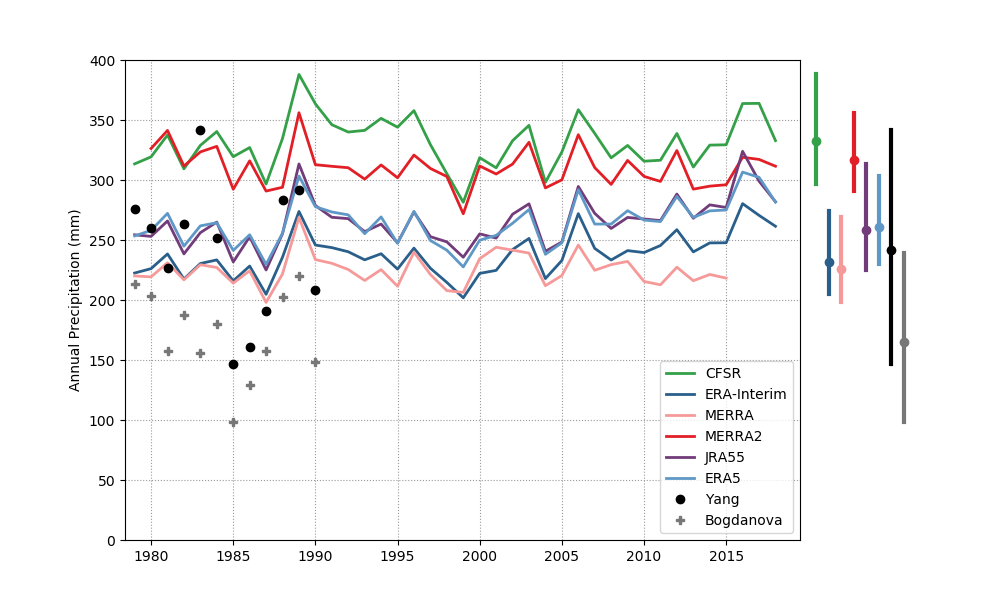

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_ylim(0,400)
ax.set_xlim(dt.datetime(1978,6,1),dt.datetime(2019,6,30))

#reanalysis.plot(ax=ax)
#yang_annual.plot(ax=ax)
#bogd_annual['P'].plot(ax=ax)
ax.plot(reanalysis.index, reanalysis.CFSR, label='CFSR', color=reanalysis_color['CFSR'], linewidth=2)
ax.plot(reanalysis.index, reanalysis.ERAI, label='ERA-Interim', color=reanalysis_color['ERAI'], linewidth=2)
ax.plot(reanalysis.index, reanalysis.MERRA, label='MERRA', color=reanalysis_color['MERRA'], linewidth=2)
ax.plot(reanalysis.index, reanalysis.MERRA2, label='MERRA2', color=reanalysis_color['MERRA2'], linewidth=2)
ax.plot(reanalysis.index, reanalysis.JRA55, label='JRA55', color=reanalysis_color['JRA55'], linewidth=2)
ax.plot(reanalysis.index, reanalysis.ERA5, label='ERA5', color=reanalysis_color['ERA5'], linewidth=2)

ax.plot(yang_annual.index, yang_annual, 'o', label='Yang', color=reanalysis_color['OBS'])
ax.plot(bogd_annual.index, bogd_annual['P'], 'P', label='Bogdanova', color=reanalysis_color['OBS2'])

handles, labels = ax.get_legend_handles_labels() # get handles and labels to plot ranges
colors = {key: value.get_color() for key, value in zip(labels, handles)}
ax.legend(loc='lower right')

ax.set_ylabel('Annual Precipitation (mm)')

ax.grid(linestyle=':', color='0.6')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
lax = plt.axes([0.81, 0.1, 0.1, 0.8], frame_on=False)
lax.set_xlim(-0.5,7.5)
lax.set_ylim(0,400)

lax.set_yticklabels([])
lax.set_xticklabels([])
lax.set_yticks([])
lax.set_xticks([])

def plot_range(x, ymin, ymax, yav, c, ax):
    ax.plot([x,x], [ymin,ymax], lw=3, color=c)
    ax.plot(x, yav, 'o', color=c)

plot_range(0., reanalysis['1979':'1991'].CFSR.min(), 
           reanalysis['1979':'1991'].CFSR.max(), reanalysis['1979':'1991'].CFSR.mean(),
           colors['CFSR'], lax)
plot_range(1., reanalysis['1979':'1991'].ERAI.min(), 
           reanalysis['1979':'1991'].ERAI.max(), reanalysis['1979':'1991'].ERAI.mean(),
           colors['ERA-Interim'], lax)
plot_range(2, reanalysis['1979':'1991'].MERRA.min(), 
           reanalysis['1979':'1991'].MERRA.max(), reanalysis['1979':'1991'].MERRA.mean(),
           colors['MERRA'], lax)
plot_range(3, reanalysis['1979':'1991'].MERRA2.min(), 
           reanalysis['1979':'1991'].MERRA2.max(), reanalysis['1979':'1991'].MERRA2.mean(),
           colors['MERRA2'], lax)
plot_range(4, reanalysis['1979':'1991'].JRA55.min(), 
           reanalysis['1979':'1991'].JRA55.max(), reanalysis['1979':'1991'].JRA55.mean(),
           colors['JRA55'], lax)
plot_range(5, reanalysis['1979':'1991'].ERA5.min(), 
           reanalysis['1979':'1991'].ERA5.max(), reanalysis['1979':'1991'].ERA5.mean(),
           colors['ERA5'], lax)

plot_range(6, yang_annual.min(), yang_annual.max(), yang_annual.mean(),
           colors['Yang'], lax)
plot_range(7, bogd_annual['P'].min(), bogd_annual['P'].max(), bogd_annual['P'].mean(),
           colors['Bogdanova'], lax)

fig.savefig('annual_precipitation_reanalysis_with_obs.eps')